# Historical data
In this example used data from forecast archives web site https://rp5.ru/

You can download current archive from direct link:
http://95.213.205.172/objects/files.from.archive/27/27612.01.01.2005.11.08.2017.1.0.0.en.utf8.00000000.csv.gz

In [1]:
%pylab inline
import pandas as pd
import os
import datetime

Populating the interactive namespace from numpy and matplotlib


## Clean historical data file

In [2]:
def clean_file(filename):
    """
    Clean historical data file and write result to new file.
    Input:
        filename : string
    Output:
        cleaned_filename : string
    """
    # Parse input file
    with open(filename) as f:
        lines = []
        for line in f:
            # Skip comment lines
            if line[0] != '#':
                line = line.replace('\n', '')
                line = line.replace('\r', '')
                if line[-1] == ';':
                    # Delete last empty delimiter
                    line = line[:-1]
                lines.append(line + '\n')

    # Write result to new file
    cleaned_filename = filename + '.cleaned.csv'
    with open(cleaned_filename, 'w') as f:
        f.writelines(lines)

    return cleaned_filename

In [3]:
filename = '../data/27612.01.01.2005.11.08.2017.1.0.0.en.utf8.00000000.csv'

print 'Cleaning...'
cleaned_filename = clean_file(filename)
print 'Cleaned filename:', cleaned_filename

Cleaning...
Cleaned filename: ../data/27612.01.01.2005.11.08.2017.1.0.0.en.utf8.00000000.csv.cleaned.csv


## Load data

In [4]:
def load_dataframe(filename):
    """
    Load dataframe from csv.
    Input:
        filename : string
    Output:
        df : pandas.core.frame.DataFrame
    """
    # Read file
    df = pd.read_csv(filename, delimiter=';', quotechar='"')
    
    # Convert string to datetime format
    df['local_time'] = pd.to_datetime(df.iloc[:,0], format='%d.%m.%Y %H:%M')
    
    # Preprocessing amount of precipitation
    df['RRR'] = df['RRR'].replace('No precipitation', 0.)
    df['RRR'] = df['RRR'].replace('Trace of precipitation', np.nan)
    df['RRR'] = pd.to_numeric(df['RRR'])
    return df
    
df = load_dataframe(cleaned_filename)
df.head()

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Local time in Moscow,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Ch,VV,Td,RRR,tR,E,Tg,E',sss,local_time
0,11.08.2017 21:00,19.5,748.0,761.8,0.1,89.0,"Calm, no wind",0.0,NaN,NaN,...,NaN,NaN,17.7,1.0,12.0,NaN,NaN,NaN,NaN,2017-08-11 21:00:00
1,11.08.2017 18:00,23.2,747.9,761.4,-0.2,76.0,"Calm, no wind",0.0,NaN,NaN,...,NaN,10.0,18.8,1.0,12.0,NaN,NaN,NaN,NaN,2017-08-11 18:00:00
2,11.08.2017 15:00,22.0,748.1,761.7,-0.4,81.0,"Calm, no wind",0.0,NaN,NaN,...,NaN,10.0,18.5,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-11 15:00:00
3,11.08.2017 12:00,19.7,748.5,762.2,-0.4,89.0,"Calm, no wind",0.0,NaN,NaN,...,NaN,4.0,17.8,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-11 12:00:00
4,11.08.2017 09:00,19.5,748.9,762.7,-0.9,75.0,Wind blowing from the south-west,1.0,NaN,NaN,...,NaN,10.0,14.9,NaN,12.0,Surface of ground moist.,17.0,NaN,NaN,2017-08-11 09:00:00


## Column types
1. T, температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли
2. Po, атмосферное давление на уровне станции (миллиметры ртутного столба)
3. P, атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)
4. U, относительная влажность (%) на высоте 2 метра над поверхностью земли
5. DD, направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период, непосредственно предшествовавший сроку наблюдения
6. FF, cкорость ветра на высоте 10-12 метров над земной поверхностью, осредненная за 10-минутный период, непосредственно предшествовавший сроку наблюдения (метры в секунду)
7. FF10, максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за 10-минутный период, непосредственно предшествующий сроку наблюдения (метры в секунду)
8. FF3, максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за период между сроками (метры в секунду)
9. Tn, минимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)
10. Tx, максимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)
11. Nh, количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдающихся облаков Cm
12. H, высота основания самых низких облаков (м)
13. VV, горизонтальная дальность видимости (км)
14. RRR, количество выпавших осадков (миллиметры)
15. sss, высота снежного покрова (см)

In [5]:
df.dtypes

Local time in Moscow            object
T                              float64
Po                             float64
P                              float64
Pa                             float64
U                              float64
DD                              object
Ff                             float64
ff10                           float64
ff3                            float64
N                               object
WW                              object
W1                              object
W2                              object
Tn                             float64
Tx                             float64
Cl                              object
Nh                              object
H                               object
Cm                              object
Ch                              object
VV                              object
Td                             float64
RRR                            float64
tR                             float64
E                        

## Plot any columns

In [6]:
def plot_values_by_dates(dates, values, title=None, path=None):
    """
    Plot of values by dates.
    Input:
        dates : np.datetime64
        values : numeric
        title : stringable
        path : string
    """
    # Convert dates format
    dates = matplotlib.dates.date2num(dates.astype(datetime.datetime))
    
    # Show plot
    plt.figure(figsize=(20,10))
    plt.plot_date(dates, values)
    if title is not None:
        plt.title(str(title))
    if path is not None:
        plt.savefig(path)
        
def hist_values(values, bins=100, title=None, path=None):
    """
    Histogram of values.
    Input:
        values : numeric
        title : stringable
        path : string
    """
    # Exclude NaN values
    mask = np.logical_not(np.isnan(values))

    # Show histogram
    plt.figure(figsize=(20,10))
    plt.hist(values[mask], bins=bins)
    if title is not None:
        plt.title(str(title))
    if path is not None:
        plt.savefig(path)

### Temperature

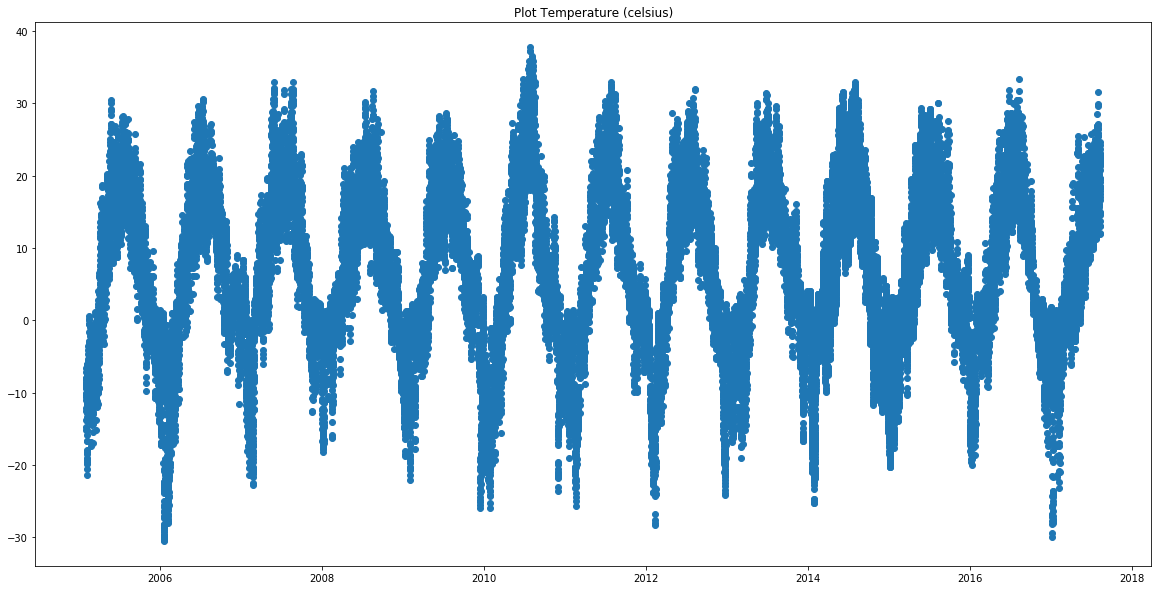

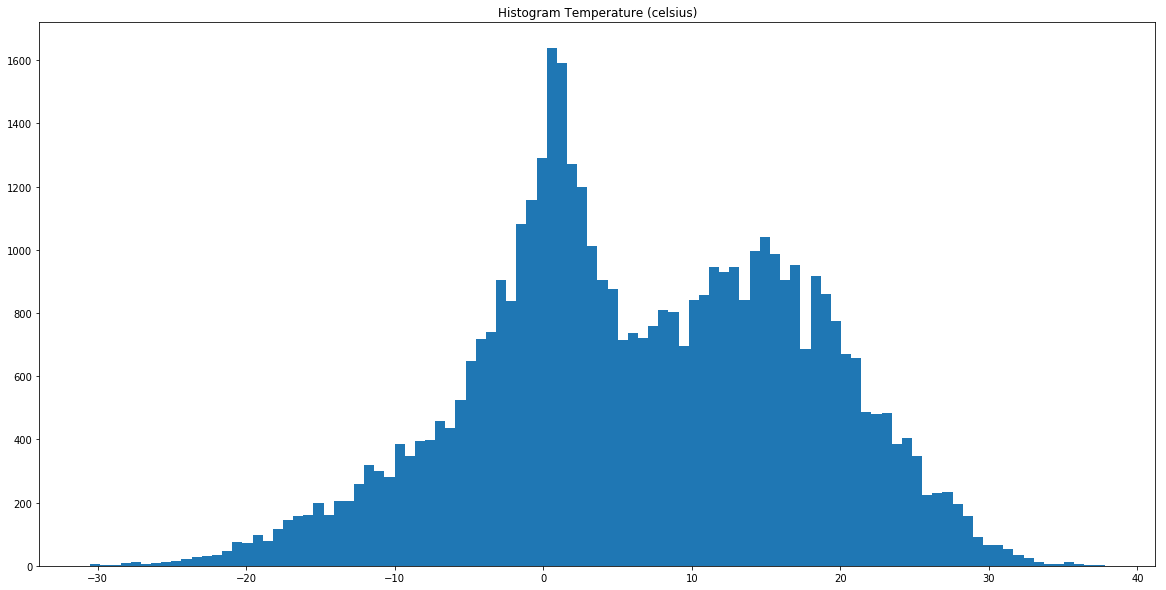

In [7]:
plot_values_by_dates(df['local_time'], df['T'], title='Plot Temperature (celsius)')
hist_values(df['T'], title='Histogram Temperature (celsius)')

### Amount of precipitation

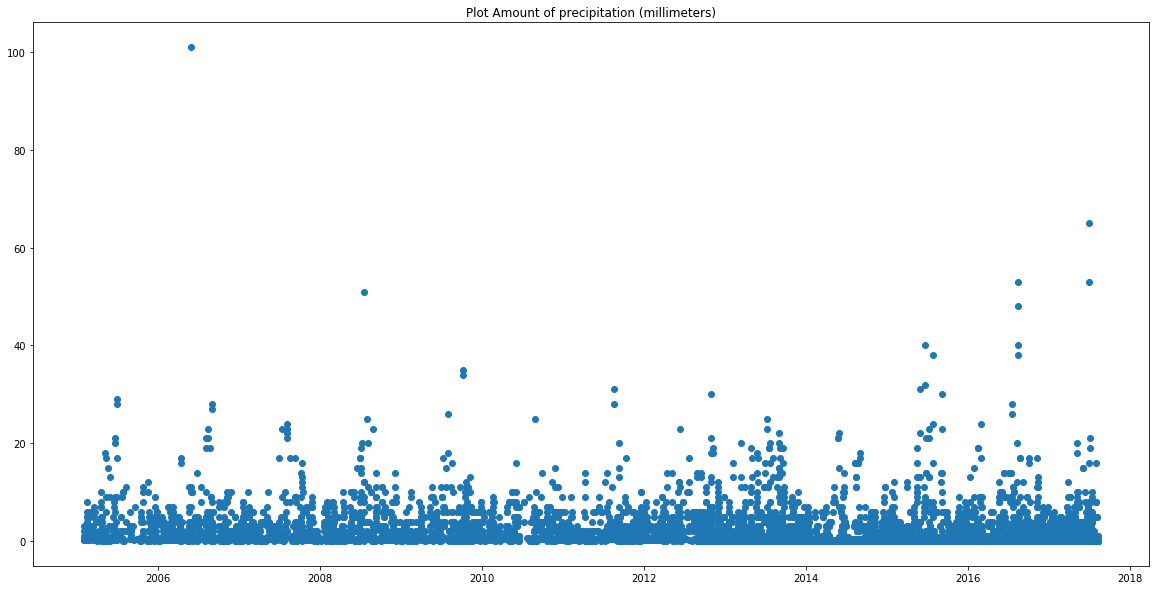

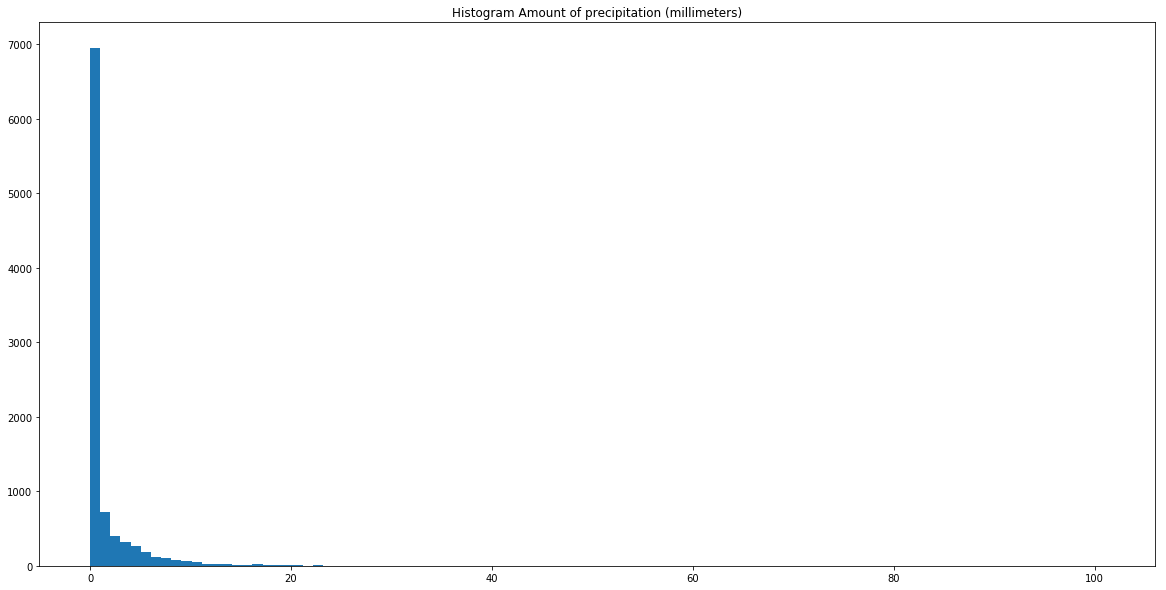

In [8]:
plot_values_by_dates(df['local_time'], df['RRR'], title='Plot Amount of precipitation (millimeters)')
hist_values(df['RRR'], title='Histogram Amount of precipitation (millimeters)')

### Atmospheric pressure at station level

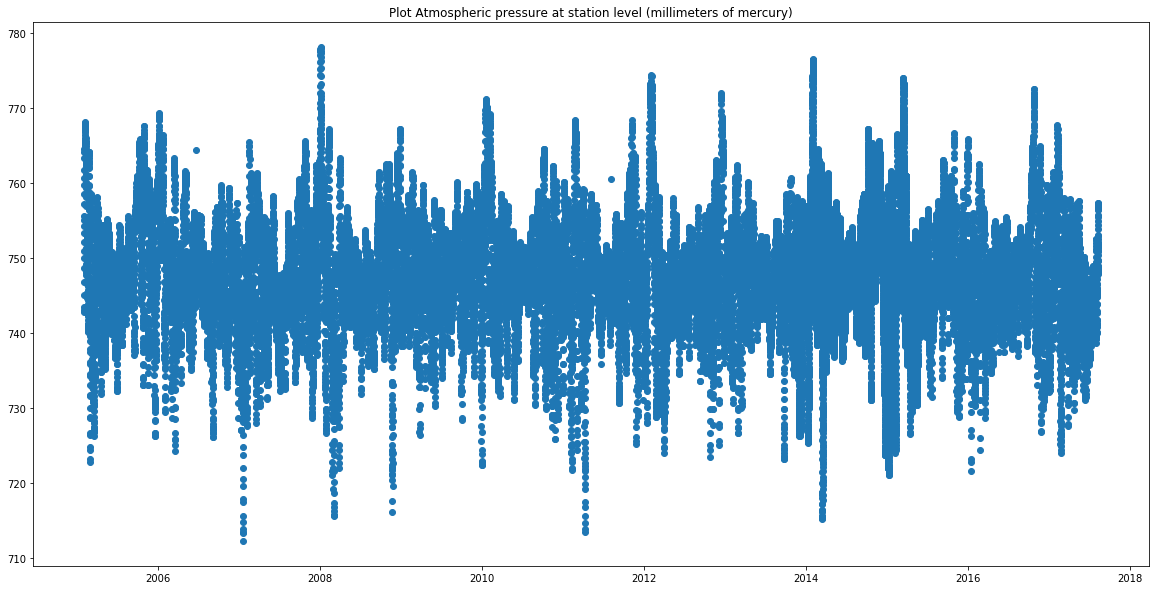

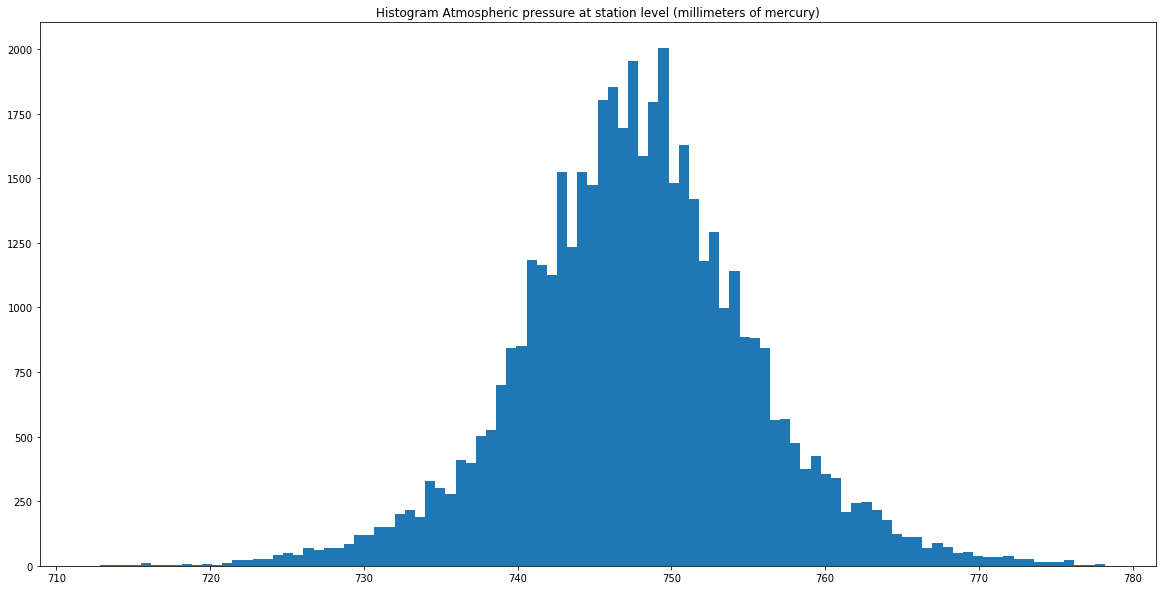

In [9]:
plot_values_by_dates(df['local_time'], df['Po'], title='Plot Atmospheric pressure at station level (millimeters of mercury)')
hist_values(df['Po'], title='Histogram Atmospheric pressure at station level (millimeters of mercury)')

### Relative humidity

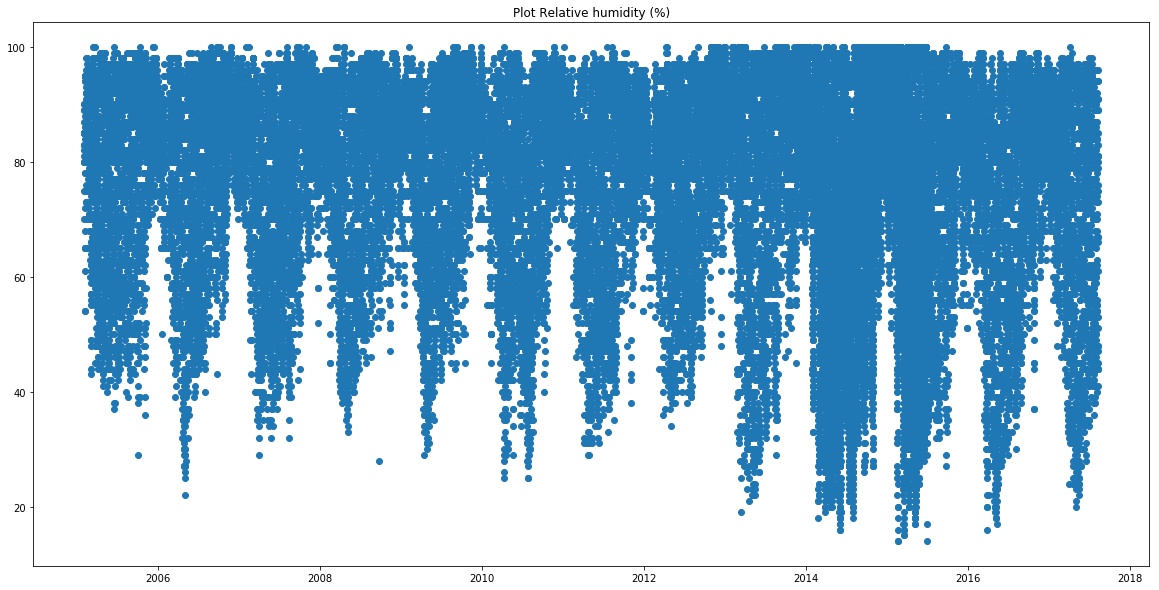

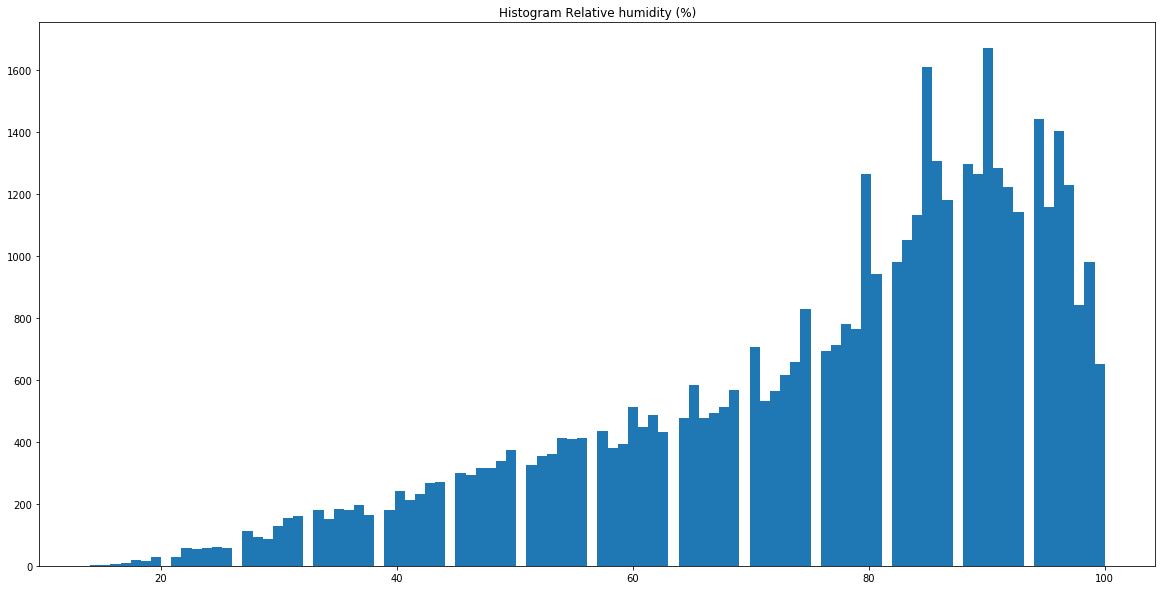

In [10]:
plot_values_by_dates(df['local_time'], df['U'], title='Plot Relative humidity (%)')
hist_values(df['U'], title='Histogram Relative humidity (%)')